(02-model-form-error)=
# Model-Form Error and Validation

Most science and engineering textbooks discuss successful cases of physical modeling, but a key part of developing a model is learning how to identify and fix model errors. *Validation* is the systematic procedure of testing a model with the endgoal of either showing the model is sufficiently accurate, or of detecting errors in the model to be fixed.

**Learning Objectives** In this chapter, you will learn

- how to use *nonlinear least squares* to fit a model
- how to inspect *residual plots* to diagnose fitting issues
- the importance of *validation data* for assessing a model
- how to recognize *model-form error*


In [1]:
import grama as gr
import numpy as np
import pandas as pd
from plotnine import *
X = gr.Intention()

### Case Study: Predicting a projectile trajectory

Our aim in this case study is to build a model to predict the trajectory of a projectile. We will use a dataset to fit unknown constants in a physics-based model, and perform validation to determine if the model is sufficiently accurate for our purposes.

To start, we will first load and inspect the data.


In [2]:
df_full = (
    pd.read_csv("../data/c01_meas_full.csv")
    >> gr.tf_mutate(source="Full")
)
df_windowed = (
    pd.read_csv("../data/c01_meas_windowed.csv")
    >> gr.tf_mutate(source="Windowed")
)


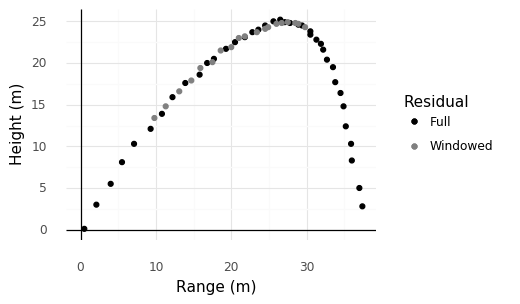

<ggplot: (8781378239237)>

In [3]:
(
    ggplot()
    + geom_hline(yintercept=0)
    + geom_vline(xintercept=0)
    + geom_point(df_full, aes("x", "y", color="source"))
    + geom_point(df_windowed, aes("x", "y", color="source"))
    
    + scale_color_manual(
        values=dict(Full="black", Windowed="grey"),
        name="Residual",
    )
    + theme_minimal()
    + theme(figure_size=(4, 3))
    + labs(x="Range (m)", y="Height (m)")
)


The projectile started at coordinates `x=0, y=0` and was launched diagonally. We actually have two sources of data; a Full set of data from launch to landing, and a Windowed set of data that covers only a fraction of the trajectory. Based on visual inspection, we can see that the data seem to be corrupted by measurement noise.


### Define the Model

We consider a projectile of fixed mass subject to gravity and drag. We consider a dynamical model for the velocity $u=dx/dt, v=dy/dt$ given by

$$m \frac{du}{dt} = F_x(u, v),$$
$$m \frac{dv}{dt} = F_y(u, v) - m g,$$

with a linear drag law

$$F_x(u, v) = - b u,$$
$$F_y(u, v) = - b v.$$

This model admits an analytical solution

$$x = \tau u_0 (1 - \exp(-t/\tau)) + x_0,$$
$$y = \tau (v_0 - v_{\infty})(1 - \exp(-t/\tau)) + v_{\infty} t + y_0,$$

where $\tau = m/b$ is the characteristic time, and $v_{\infty} = g \tau$ is the terminal velocity.

Since $x_0, y_0$ are known, we have just three unknown quantities to fit:

| Sym. | Quantity |
|---|---|
| $u_0$ | Initial velocity; horizontal |
| $v_0$ | Initial velocity; vertical |
| $\tau$ | Characteristic time |


Below we will need plausible ranges for $u_0, v_0, \tau$ in order to fit these values. To that end, let's perform a coarse analysis of the available data. For $u_0, v_0$ we will simply study the observed velocity components, estimated by simple finite differences. For the time constant $\tau$ we will study the relationship between the (finite-difference based) speed and acceleration. These will be very crude estimates, but they will set an appropriate sense of scale for the values.


In [4]:
df_speeds = (
    df_full
    ## Approximate velocities with finite differences
    >> gr.tf_mutate(
        u=(gr.lead(X.x) - X.x) / (gr.lead(X.t) - X.t),
        v=(gr.lead(X.y) - X.y) / (gr.lead(X.t) - X.t),
    )
    ## Compute speed from component velocities
    >> gr.tf_mutate(s=gr.sqrt(X.u**2 + X.v**2))
    ## Approximate acceleration with finite differences
    >> gr.tf_mutate(a=(gr.lead(X.s) - X.s) / (gr.lead(X.t) - X.t))
    ## Statistics of absolute values
    >> gr.tf_mutate(
        u_abs=gr.abs(X.u),
        v_abs=gr.abs(X.v),
        tau_abs=gr.abs(X.s / X.a),
    )
    >> gr.tf_select(X.u_abs, X.v_abs, X.tau_abs)
)
df_speeds >> gr.tf_describe()

,u_abs,v_abs,tau_abs
count,38.000000,38.00000,37.000000
mean,9.710526,12.50000,1.314464
std,5.367106,8.76649,2.467240
min,0.000000,1.00000,0.064224
25%,6.000000,5.00000,0.214345
50%,9.000000,11.00000,0.503272
75%,13.750000,19.50000,1.179365
max,22.000000,33.00000,13.816485


We will use the data above to set informed lower-bounds on the quantities. While the max values are not realistic for best-fit values, we will set them as an upper bound to help focus the parameter search below.


In [5]:
u0_bounds = (df_speeds.u_abs.min(), df_speeds.u_abs.max())
v0_bounds = (df_speeds.v_abs.min(), df_speeds.v_abs.max())
tau_bounds = (df_speeds.tau_abs.min(), df_speeds.tau_abs.max())
print("u0: ", u0_bounds)
print("v0: ", v0_bounds)
print("tau: ", tau_bounds)

u0:  (0.0, 22.000000000000014)
v0:  (0.9999999999999778, 32.99999999999998)
tau:  (0.06422436149609652, 13.816485066214396)


### Implement the model

Here we implement the model described above in Grama. We will use this with a fitting routine to estimate best-fit values for $u_0, v_0, \tau$.


In [6]:
## Constants
x0 = 0 # Initial x-position (m)
y0 = 0 # Initial y-position (m)
g = -9.8 # Gravitational acceleration (m/s^2)

## Responses (x and y trajectory components)
def fun_x(x):
    u0, v0, tau, t = x
    return tau * u0 * (1 - np.exp(-t/tau)) + x0

def fun_y(x):
    u0, v0, tau, t = x
    v_inf = g * tau
    return tau * (v0 - v_inf) * (1 - np.exp(-t/tau)) + v_inf * t + y0

# Units     (m/s) (m/s) (s)    (s)
var_list = ["u0", "v0", "tau", "t"]

## Assemble model
md_trajectory = (
    gr.Model("Trajectory Model")
    >> gr.cp_function(
        fun=fun_x,
        var=var_list,
        out=["x"],
        name="x_trajectory",
    )
    >> gr.cp_function(
        fun=fun_y,
        var=var_list,
        out=["y"],
        name="y_trajectory",
    )
    >> gr.cp_bounds(
        u0=u0_bounds,
        v0=v0_bounds,
        tau=tau_bounds,
        t=(0, 60),
    )
)

md_trajectory.printpretty()

model: Trajectory Model

  inputs:
    var_det:
      u0: [0.0, 22.000000000000014]
      v0: [0.9999999999999778, 32.99999999999998]
      t: [0, 60]
      tau: [0.06422436149609652, 13.816485066214396]

    var_rand:

    copula:
      None

  functions:
      x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
      y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']



### Fit the Model with Nonlinear Least Squares

In the previous chapter we discussed *ordinary least squares*; fitting a model *linear in its features* to a dataset. Now we will consider *nonlinear least squares* (NLS); fitting a model *nonlinear in its features*. For more information, see the [appendix entry on NLS](04-nls).

We will use the `gr.fit_nls()` routine to carry out NLS to find a best-fit value for $\theta$. This function takes a model and a datset, infers the outputs (`out`), the variables to set constant (`var_fix`), the variables to treat as features in the dataset (`var_feat`), and the variables to treat as parameters for optimization. The routine uses the bound information from the model to impose during optimization, and to inform the initial guess $\theta_0$.

Furthermore setting `uq_method="linpool"` uses a linear approximation of the model to infer a distribution for the parameter vector $\theta$. This will allow us to simulate an ensemble of plausible trajectories that are compatible with our data.


In [7]:
md_fit = (
    df_windowed
    >> gr.ft_nls(
        md=md_trajectory,
        uq_method="linpool",
    )
)
md_fit.printpretty()

... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
          u0         v0       tau  u0_0  v0_0     tau_0  success  \
0  18.792164  28.234799  2.802251  11.0  17.0  6.940355     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL      19  0.093358  
... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}
model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)

    var_rand:
      u0: (+0) norm, {'loc': 18.792164108555788, 'scale': 0.17265625005146742}
      v0: (+0) norm, {'loc': 28.234799030915262, 'scale': 0.19741816344413898}
      tau: (+0) norm, {'loc': 2.8022508095940344, 'scale': 0.12681169895779346}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0   u0   v0  0.000000
1   u0  tau -0.678972
2   v0  tau -0.704769

  functions:
      T

Note that `ft_nls()` is a fitting routine, so it returns a model. Also note that the new model has normal marginals for the fitted parameters; the assumptions underlying the `linpool` UQ method result in a multivariate Gaussian distribution for the parameters. Evaluating the model with `ev_monte_carlo()` draws samples from the fitted parameter distribution, allowing us to visualize a "cone of uncertainty" associated with our fitted model. This will give us a visual sense of output variability, which is helpful for judging if the data lie near or far from the model results.


... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


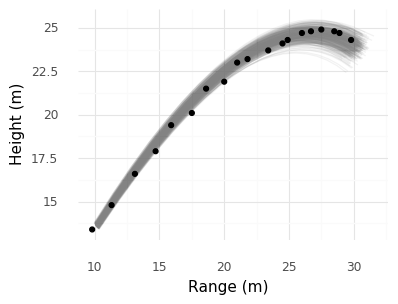

<ggplot: (8781379417105)>

In [8]:
df_res_windowed = (
    md_fit
    >> gr.ev_monte_carlo(n=500, df_det=df_windowed, seed=101)
)

(
    ggplot(mapping=aes("x", "y"))
    + geom_line(
        data=df_res_windowed, 
        mapping=aes(group="tau"), 
        alpha=1/10, 
        size=0.5,
        color="grey",
    )
    + geom_point(df_windowed)
    + theme_minimal()
    + theme(figure_size=(4, 3))
    + labs(x="Range (m)", y="Height (m)")
)

Stop and ask yourself "is this model validated?" Qualitatively the fit seems to be quite good. Based on these results alone, we might be tempted to say the model is validated. However, keep in mind that NLS chooses the *best* parameter values $\theta$ to fit the data at hand; like with an empirical model, assessing a fitted physics-based model against its training data will tend to give an optimistic sense of model accuracy.

There two analyses we should complete before declaring this model validated: We should *inspect residuals*, and we should check our model against *validation data*.


### Inspect the Residuals

A *residual* is a discrepancy between the observed and modeled values, that is

$$r_i = \hat{f}_i(\theta) - f_i.$$

The quantity $r_i$ is "residual" in the sense that it is what is "left over" after fitting a model. A classical idea in statistics is to study the residuals after fitting, in order to determine if there are patterns "left over" that the fitted model does not capture {cite}`mosteller1977data`. Obvious patterns may suggest our model is inadequate; or in the case of a physical model, that our modeling assumptions were erroneous.

First we compute the residuals at the nominal (best-fit) model results.


In [9]:
df_resid_windowed = (
    md_fit
    >> gr.ev_nominal(df_det=df_windowed)
    >> gr.tf_transmute(x_pred=X.x, y_pred=X.y, t=X.t)
    >> gr.tf_bind_cols(df_windowed[["x", "y"]])
    >> gr.tf_mutate(
        x_resid=X.x_pred - X.x,
        y_resid=X.y_pred - X.y,
    )
)

... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


Next we construct a residual-vs-feature plot; in this case `x_resid, y_resid` against `t`. We also add a smoothed trendline to help visualize the trends in the residuals.


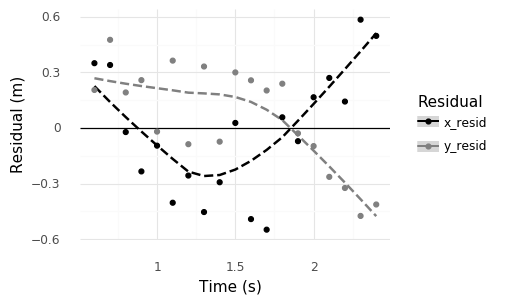

<ggplot: (8781379611117)>

In [10]:
(
    ggplot(
        df_resid_windowed >> gr.tf_gather("var", "resid", ["x_resid", "y_resid"]), 
        aes("t", "resid", color="var")
    )
    + geom_hline(yintercept=0)
    + geom_smooth(linetype="dashed")
    + geom_point()
    + scale_color_manual(
        values=dict(x_resid="black", y_resid="grey"),
        name="Residual",
    )
    + theme_minimal()
    + theme(figure_size=(4, 3))
    + labs(x="Time (s)", y="Residual (m)")
)

If all our model was missing was the noise on our measurements, then we would expect the residuals to be randomly distributed about zero; the residuals should have no coherent pattern across time (or any other feature). This residual plot shows that there is some "residual" pattern that our model does not capture. In the `y` coordinate, the projectile is first too high (`y_resid > 0`) then too low (`y_resid < 0`). Note how these patterns are much easier to see in a residual plot, rather than in a "straight" comparison against the data.

Of course, we will not always have a single feature in our model. In the more general case, we can plot the residual $r_i$ against its predicted value $\hat{f}_i$. The next figure shows `x_resid` against `x_pred`.


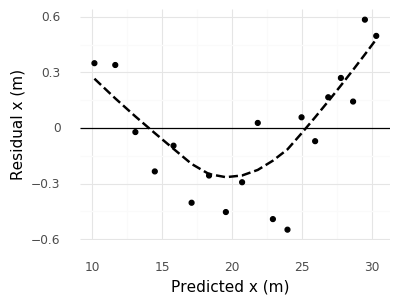

<ggplot: (8781379748189)>

In [11]:
(
    ggplot(
        df_resid_windowed,
        aes("x_pred", "x_resid")
    )
    + geom_hline(yintercept=0)
    + geom_smooth(linetype="dashed")
    + geom_point()
    + theme_minimal()
    + theme(figure_size=(4, 3))
    + labs(x="Predicted x (m)", y="Residual x (m)")
)

Since the projectile is advancing steadily, this plot is very similar to the one above. Again, we see a strong pattern in the residuals, suggesting the model is underfit, possibly by erroneous modeling choices. Note that plotting the residual against its predicted value is recommended over plotting the residual against the *observed* value, as the latter approach can lead to misleading plots {cite}`gelman2020regression`.


### Inspect Model with Validation Data

*Validation data* are data which have been purposefully held-out of the model-building process, and set aside for the purposes of assessing the model. Ideally, the person building the model should not get to "see" these data before testing the model {cite}`james2013introduction`. As discussed in the chapter on Model Flexibility, our data-splitting scheme should be tailored to our intended use. 

Here we evaluate the model on the Full dataset and inspect the fit.

... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


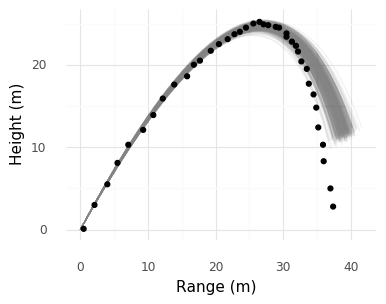

<ggplot: (8781379746125)>

In [12]:
df_res_full = (
    md_fit
    >> gr.ev_monte_carlo(n=500, df_det=df_full, seed=101)
)

(
    ggplot(mapping=aes("x", "y"))
    + geom_line(
        data=df_res_full, 
        mapping=aes(group="tau"), 
        alpha=1/10, 
        size=0.5,
        color="grey",
    )
    + geom_point(df_full)
    + theme_minimal()
    + theme(figure_size=(4, 3))
    + labs(x="Range (m)", y="Height (m)")
)

Here the inadequacy of the fit is obvious; the simulated projectile is widely overshooting the real trajectory. The real projectile is also much lower at its endtime, as compared with the end of each simulated trajectory (which are much too high at the same time). It appears the simulated projectile is moving too fast towards its peak, suggesting that the initial speed is too large or the drag force is too small.

A residual plot gives an evern sharper look at this lack of fit.


... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


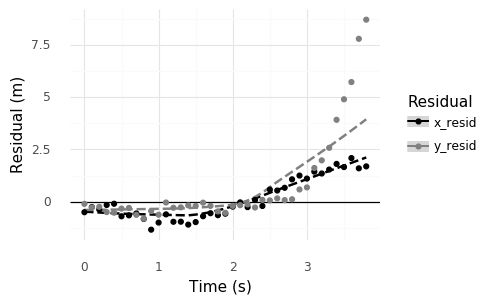

<ggplot: (8781380360677)>

In [13]:
df_res_resid = (
    md_fit
    >> gr.ev_nominal(df_det=df_full)
    >> gr.tf_transmute(x_pred=X.x, y_pred=X.y, t=X.t)
    >> gr.tf_bind_cols(df_full[["x", "y"]])
    >> gr.tf_mutate(
        x_resid=X.x_pred - X.x,
        y_resid=X.y_pred - X.y,
    )
    >> gr.tf_gather("var", "resid", ["x_resid", "y_resid"])
)

(
    ggplot(df_res_resid, aes("t", "resid", color="var"))
    + geom_hline(yintercept=0)
    + geom_smooth(linetype="dashed")
    + geom_point()
    + scale_color_manual(
        values=dict(x_resid="black", y_resid="grey"),
        name="Residual",
    )
    + theme_minimal()
    + theme(figure_size=(4, 3))
    + labs(x="Time (s)", y="Residual (m)")
)

These two plots indicate that the model is incapable of making accurate predictions for this scenario: It has *model-form error* that precludes predictive accuracy.


### Exercise

We've seen that we can't make a successful prediction with this model, but can the model represent the full trajectory at all? Try fitting the trajectory model `md_trajectory` to `df_full`; can you accurately represent the data using this model?

### Recognize Model-form Error

Model-form error (sometimes called model discrepancy) occurs when the model in use cannot accurately represent the underlying physics {cite}`smith2013uncertainty`. The inability of the linear drag model to fit the data indicates that there is model-form error.

In truth, the data above were generated not with a linear drag law, but rather with a *quadratic* drag law:

$$F_x(u, v) = - b u^2 / \sqrt{u^2+v^2}$$
$$F_y(u, v) = - b v^2 / \sqrt{u^2+v^2}$$

This is the specific model-form error in the present case study. The uncaptured nonlinearity in the drag force leads to an erroneous trajectory, explaining the results we saw above. For instance, the nonlinear drag law breaks the left-right symmetry of the trajectory, a feature of the trajectory that the linear drag model cannot represent.

In general, model-form errors are simultaneously *the most consequential source of uncertainty* in physical modeling and *the most difficult source of uncertainty* to address.


### Address Model-form Errors

There are two broad approaches to addressing model-form errors {cite}`smith2013uncertainty`:

1. Improve the physical model
1. Model the discrepancy

One can **improve the physical model** by hunting down missing physics or erroneous assumptions and correcting those mistakes. Since the present case study is synthetic, the model-form error can be totally corrected by exchanging the linear drag law for a quadratic one. However this will not always be possible, as our understanding of physics is incomplete. There are no generic techniques for improving the physical model, as doing so requires domain-specific knowledge of the problem, and a sufficiently accurate physics-based model may not presently exist.

Rather than take a physics-based approach, one may alternatively **model the discrepancy**. Using the empirical modeling techniques discussed in the chapter on model flexibility, one can fit a model for the discrepancy between model results and measured data.

For instance, in the present case study the (horizontal) linear drag force is given as a function of physical quantities $F_x = F_x(u, v; \tau)$. One could introduce additional parameters in an empirical model $\hat{F}_x = \hat{F}_x(u, v; \tau, \theta) = F_x(u, v; \tau) + \delta_x(u, v; \theta)$. The new discrepancy term $\delta$ would compensate for the incorrect physical assumptions, with the new $\theta$ tuned during NLS fitting.

In the chapter on principled predictions, we will demonstrate how to fit such a discrepancy model, and how to quantify uncertainty within this framework.


## Key Takeaways

- Nonlinear least squares (NLS) can help us find best-fit parameter values (and even a parameter distribution) for a physics-based model. However, assessing a fitted physics-based model against its training data will give an optimistic sense of accuracy.
- Residual plots help us detect missing patterns in a model and can help identify cases of model-form error.
- Validation data is data withheld from the model during training, and can be used for an "honest" assessment of model accuracy.
- Model-form error occurs when the model has missing or incorrect physical behavior(s); both residual plots and validation data can help to identify model-form errors. 
